# Agents

An Agentic LLM application is an application which uses an LLM to pick from one or more possible courses of action, given some context about the current state of the world or some desired next state. These are implemented by following.
- **Tool Calling** includes a list of external functions that LLM can make use of in your prompt and provide instructions on how to format its choice in the output it generates.
- **Chain of Thought** is an idea to ask LLM to reason about complex problems by breaking them down into granular steps. This is usually done by adding "think step by step" or including examples of problem decomposition.

The recent LLMs and models have been fine-tuned to improve their performance for tool-calling and chain-of-thoguht applications, removing the need for specific instructions in the prompt.

## Plan-Do Loop

The LLM is given the authority to decide what actions to take. For example, if you had a `search` tool to search the web, when you ask for some information, it can use this tool to decide next step.

This architecture, called **ReAct** was proposed by Shunyu Yao. 

### LangGraph Agent

For implementing search functionality, you can use DuckDuckGo. You can install the required package using `uv add duckduckgo-search`. Next, you can define your Graph with LangGraph below.

In [1]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
# from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI
from langchain_ollama import ChatOllama

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
# model = ChatOpenAI(temperature=0.1).bind_tools(tools)
model = ChatMistralAI(model='mistral-large-latest', temperature=0.1).bind_tools(tools)
# model = ChatOllama(model='gpt-oss:20b', temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

Let's visualize the graph.

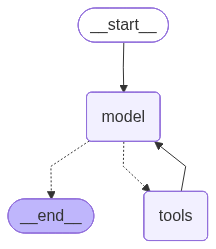

In [2]:
from IPython.display import Image, display

graph_png = graph.get_graph().draw_mermaid_png()
display(Image(graph_png))

Here, you have defined two tools: a search tool and a calculator tool. 
- You defined a new tool using `@tool` decorator over a Python function. Make sure to always add docstring because that is the information passed to the LLM. `ToolNode` serves as a node in our graph. This executes th tool calls requested in the latest AI message found in the state and returns a `ToolMessage` with the results of each. `ToolNode` also handles exceptions raised by tools-using the error message to build a `ToolMessage` that is passed to LLM-which may decide what to do with the error.
- `tools_conditions` is a conditional edge function that looks at the latest AI message in the state and routes to the `tools` node if there are any tools to execute, otherwise end the graph.
- The graph is a bi-directional between the model and tool nodes. That means the model itself decides when to end the computation which is a characteristic of agent architecture. Whenever you code a loop in LangGraph, you'll want to use a conditional edge because this lets you define the stop condition when the graph should exit the loop and stop execution.

In [3]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

input = {
    "messages": [
        HumanMessage("""How old was the 30th president of the United States 
            when he died?""")
    ]
}
for c in graph.stream(input):
    print(c)

{'model': {'messages': AIMessage(content="The 30th president of the United States was **Calvin Coolidge**. He was born on **July 4, 1872**, and died on **January 5, 1933**.\n\nLet's calculate his age at the time of his death.", additional_kwargs={'tool_calls': [{'id': 'bMwHM1Y1l', 'function': {'name': 'calculator', 'arguments': '{"query": "(1933 - 1872) - ( (1 + 5) / 31 )"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 179, 'total_tokens': 271, 'completion_tokens': 92}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run--c339f9d4-79f3-423d-a64e-6566b457c3f5-0', tool_calls=[{'name': 'calculator', 'args': {'query': '(1933 - 1872) - ( (1 + 5) / 31 )'}, 'id': 'bMwHM1Y1l', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 92, 'total_tokens': 271})}}
{'tools': {'messages': [ToolMessage(content="Error: ValueError('malformed node or string on line 1: <ast.BinOp object at 0x12f9dde10>'

### Always Call Tool First

In standard agent architecture, LLM has the flexibility to decide which tool to call, but this flexibility comes at cost of unpredictability. If you always want the `search` tool called first, that can be beneficial to your application. This will reduce your overall latency as it will skip the first LLM call to decide which tool to call and it will also prevent LLM from erroneously deciding it doesn't need a tool call for some queries. However, this means if your application doesn't have clear rule of which tool to call first, adding these kindso f constraints would mek your application worse.

In below code, you add the `first_model` as a search tool.

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("Obama")

/Users/piyushpatel/IdeaProjects/langchain-exploration/.venv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'No good DuckDuckGo Search Result was found'

In [5]:
import ast
from typing import Annotated, TypedDict
from uuid import uuid4

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AIMessage, HumanMessage, ToolCall
from langchain_core.tools import tool
# from langchain_openai import ChatOpenAI
from langchain_mistralai import ChatMistralAI

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
# model = ChatOpenAI(temperature=0.1).bind_tools(tools)
model = ChatMistralAI(
    model='mistral-large-latest', 
    temperature=0
).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

def first_model(state: State) -> State:
    query = state["messages"][-1].content
    search_tool_call = ToolCall(
        name="duckduckgo_search", args={"query": query}, id=uuid4().hex
    )
    return {"messages": AIMessage(content="", tool_calls=[search_tool_call])}


builder = StateGraph(State)
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

/var/folders/gb/6k7kx0813nj31c19df8s6xs40000gp/T/ipykernel_41682/3935946182.py:23: ResourceWarning: unclosed <ssl.SSLSocket fd=104, family=2, type=1, proto=0, laddr=('192.168.2.22', 60741), raddr=('104.18.23.152', 443)>
  model = ChatMistralAI(


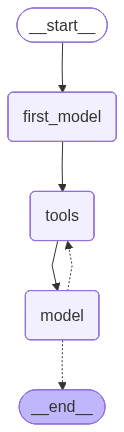

In [6]:
from IPython.display import Image, display

graph_png = graph.get_graph().draw_mermaid_png()
display(Image(graph_png))

In above graph, ou start all invocations by calling `first_model`. It creats a tool call for the search tool using user's message as the search query.  After this, you proceed to `tools` and from there you proceed to the `agent` node as before.

In [7]:
input = {
    "messages": [
        HumanMessage("""How old was the 30th president of the United States 
            when he died?""")
    ]
}
for c in graph.stream(input):
    print(c)

/Users/piyushpatel/IdeaProjects/langchain-exploration/.venv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='7e0b95aa-db73-4f5f-a07a-41c9d70f80fe', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'How old was the 30th president of the United States \n            when he died?'}, 'id': 'd8f842f235134df4ae14d91163e3c102', 'type': 'tool_call'}])}}
{'tools': {'messages': [ToolMessage(content='Feb 19, 2025 · 升级win11后，windows.old文件夹可以删除。以下是删除windows.old的五种方法： 方法一：从文件资源管理器删除 - 打开文件资源管理器（Windows+E）。- 转到C盘，选择windows.old文件夹。-  … May 2, 2025 · c盘windows.old文件夹可以删除。以下是关于windows.old文件夹及其删除方法的详细解答： 一、windows.old文件夹内容 windows.old文件夹里面包含的是以往系统和安装程序的备份文件。这些文件在 … 电脑从 Window 10 升级到了 Window 11 后，发现系统 C 盘剩余空间小了很多，于是查看了一番，发现了一个占用空间超大的 Window.old， 这个文件夹是旧系统文件，如果不准备回退到以前的系统，是可以删除的， … Jul 24, 2024 · Windows.old是Windows系统更新或重装后留下的旧系统文件夹，通常可以删除，但需要谨慎操作。 以下是关于Windows.old文件夹的 一、Windows.old文件夹的含义 Windows.old文件夹是在进行系统 … Jan 26, 2024 · 有old, old, elder, elderly四个单词，有什么区别吗？这四个单词都有“老的、年长的”含义，但是根据不同的语境，它们在平时生活中的用法是不一样

/Users/piyushpatel/IdeaProjects/langchain-exploration/.venv/lib/python3.11/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


{'model': {'messages': AIMessage(content='The 30th president of the United States was **Calvin Coolidge**. He was **60 years old** when he died on January 5, 1933.', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 1159, 'total_tokens': 1199, 'completion_tokens': 40}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'stop'}, id='run--e13c2dab-894a-43e5-b8e9-18c8fa9e2d25-0', usage_metadata={'input_tokens': 1159, 'output_tokens': 40, 'total_tokens': 1199})}}


From above message calls, you can see first call was with `first_model` node which returned a tool call for the search tool. From there, it went to the model to calculate the age.

### Dealing with Many Tools

When there are multiple choices or excessive information in a prompt, LLMs tend to struggle. When given many tools (more than 10), the planning performance starts to suffer. So, you have to reduce the number of tools LLM can choose from. If you want to have many tools, you could use RAG step to preselect the most relevant tools for the current query and then feed the LLM only that subset of tools instead of the entire toolset. This will also reduce cost of LLM calls. This RAG step introduces additional latency in your application and thus should be considered only when performance decreases after adding more tools.

In [8]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
# from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_mistralai import ChatMistralAI
from langchain_ollama import OllamaEmbeddings

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]

# embeddings = OpenAIEmbeddings()
# model = ChatOpenAI(temperature=0.1)
embeddings = OllamaEmbeddings(model='embeddinggemma')
model = ChatMistralAI(model='mistral-large-latest', temperature=0.1)

# Create embeddings for tools
tools_retriever = InMemoryVectorStore.from_documents(
    [
        Document(
            tool.description, 
            metadata={"name": tool.name}) for tool in tools
    ],
    embeddings,
).as_retriever()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [
        tool for tool in tools if tool.name in state["selected_tools"]
    ]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}


# Build Graph
builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

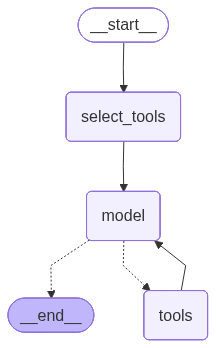

In [9]:
from IPython.display import Image, display

graph_png = graph.get_graph().draw_mermaid_png()
display(Image(graph_png))

In this case, you stop by the `select_tools` node before entering agent loop.

Let's query this agent with a query which needs search tool.

In [10]:
input = {
  "messages": [
    HumanMessage("""How old was the 30th president of the United States when 
        he died?""")
  ]
}
for c in graph.stream(input):
    print(c)

{'select_tools': {'selected_tools': ['duckduckgo_search', 'calculator']}}
{'model': {'messages': AIMessage(content="The 30th president of the United States was **Calvin Coolidge**. He was born on **July 4, 1872**, and died on **January 5, 1933**.\n\nLet's calculate his age at the time of his death.", additional_kwargs={'tool_calls': [{'id': '4Sh4FJqqi', 'function': {'name': 'calculator', 'arguments': '{"query": "(January 5, 1933 - July 4, 1872) in years"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 179, 'total_tokens': 269, 'completion_tokens': 90}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run--c979be56-1aa2-4153-8035-085d80a31ecd-0', tool_calls=[{'name': 'calculator', 'args': {'query': '(January 5, 1933 - July 4, 1872) in years'}, 'id': '4Sh4FJqqi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 90, 'total_tokens': 269})}}
{'tools': {'messages': [ToolMessage(conten

There are couple of extensions to the agent architecture that can improve performance for some use cases.
- **Reflection** is about giving LLM the opportunity to analyze its past output and choices, together with the ability to remember reflections from past iterations.
- **Multi-agent** is about having multiple LLM tackle a single problem.

### Reflection

It is the creation of a loop between a creator prompt and a reviser prompt. Reflection can be combined with other techniques such as chain-of-thought and tool calling. When applied correctly, self-critique can help LLM applications get closer to a system that resembles methodical and reflective.

In below code, reflection is implemented as a graph with two nodes: `generate` and `reflect`. This is about generating essays where `generate` is used for writing and `reflect` is used to critique to inform the next revision.

In [11]:
from typing import Annotated, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
# from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

# model = ChatOpenAI()
model = ChatOllama(model='gpt-oss:20b')

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

generate_prompt = SystemMessage(
    """You are an essay assistant tasked with writing excellent 3-paragraph 
        essays."""
    "Generate the best essay possible for the user's request."
    """If the user provides critique, respond with a revised version of your 
        previous attempts."""
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages": [answer]}

reflection_prompt = SystemMessage(
    """You are a teacher grading an essay submission. Generate critique and 
        recommendations for the user's submission."""
    """Provide detailed recommendations, including requests for length, depth, 
        style, etc."""
)

def reflect(state: State) -> State:
    # Invert the messages to get the LLM to reflect on its own output
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    # First message is the original user request. 
    # We hold it the same for all nodes
    translated = [reflection_prompt, state["messages"][0]] + [
        cls_map[msg.__class__](content=msg.content) 
            for msg in state["messages"][1:]
    ]
    answer = model.invoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=answer.content)]}

def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations, each with 2 messages
        return END
    else:
        return "reflect"

builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()

/Users/piyushpatel/.pyenv/versions/3.11.11/lib/python3.11/inspect.py:1226: ResourceWarning: unclosed <ssl.SSLSocket fd=112, family=2, type=1, proto=0, laddr=('192.168.2.22', 60785), raddr=('104.18.23.152', 443)>
  blockfinder.tokeneater(*_token)


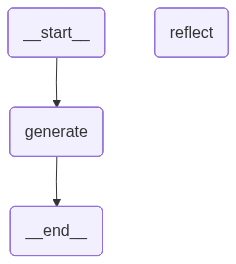

In [12]:
from IPython.display import Image, display

graph_png = graph.get_graph().draw_mermaid_png()
display(Image(graph_png))

The `reflect` node tricks LLM into thinking it is critiquing essays written by the user and `generate` node is made to think that the critique comes from the user. In this case, the generate reflect loop terminates after `generate` so that last set of revisions are dealt with. A variation on this architecture would have the `reflect` step make the decision to end the process.

This simple reflection can sometimes improve performance by giving LLM multiple attempts at refining its output. You could also use the reflection step as the last node right before sending output to the user. For example, in coding agent, you could add a step before `reflect` that could run the code through linter/compiler and report any errors as input to the `reflect`. This approach is likely to increase the quality of the final output.

## Subgraphs

Subgraphs are graphs that are used as part of another graph. They can be used for following use cases.
- Building multi-agent systems
- When you want to reuse a set of nodes in multiple graphs, you can define them once in a subgraph and then use them in multiple graphs.
- When you want different teams to work on different parts of the graph independently, you can define each part as a subgraph. The parent graph can be built without knowing any details of the subgraph.

Subgraphs can be added in two ways to a parent graph.
1. Add a node that calls the subgraph directly. This can be used when parent graph and the subgraph share state keys and you don't need to transform state on the way in or out.
2. Add a node with a function that invokes the subgraph. This can be used when the parent graph and subgraph have different state schemas and you need to transform state before or after calling the subgraph.

### 1. Calling Subgraph directly

The simplest way to create subgraph is to attach a subgraph as a node. It is important that the parent graph and subgraph share state keys because those will be used to communicate. If you pass extra keys to the subgraph node (in addition to the shared keys), they will be ignored by the subgraph node. Similarly, if you return extra keys from the subgraph, they will be ignored by the parent graph.

```python
from langgraph.graph import START, StateGraph
from typing import TypedDict

class State(TypedDict):
    foo: str # this key is shared with the subgraph

class SubgraphState(TypedDict):
    foo: str # this key is shared with the parent graph
    bar: str

# Define subgraph
def subgraph_node(state: SubgraphState):
    # note that this subgraph node can communicate with the parent graph 
    # via the shared "foo" key
    return {"foo": state["foo"] + "bar"}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node)
...
subgraph = subgraph_builder.compile()

# Define parent graph
builder = StateGraph(State)
builder.add_node("subgraph", subgraph)
...
graph = builder.compile()
```

### 2. Calling Subgraph with a Function

When you want ot define a subgraph with a completely different schema, you can create a node with a function that invokes the subgraph. This function will need to transform the input (parent) sate to the subgraph state before invoking the subgraph and transform the results back to the parent state before returning the state update from the node.

```python
class State(TypedDict):
    foo: str

class SubgraphState(TypedDict):
    # none of these keys are shared with the parent graph state
    bar: str
    baz: str

# Define subgraph
def subgraph_node(state: SubgraphState):
    return {"bar": state["bar"] + "baz"}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node)
...
subgraph = subgraph_builder.compile()

# Define parent graph
def node(state: State):
    # transform the state to the subgraph state
    response = subgraph.invoke({"bar": state["foo"]})
    # transform response back to the parent state
    return {"foo": response["bar"]}

builder = StateGraph(State)
# note that we are using `node` function instead of a compiled subgraph
builder.add_node(node)
...
graph = builder.compile()
```

## Multi-Agent Architectures

As LLM agents grow in size, scope or complexity, several issues can show up and impact their performance.
- The agent is given too many tools and makes poor decisions about which tool to call next.
- The context grows too complex for a single agent to keep track of. The size of the prompts and the number of things they mention grows beyond the capability of the model.
- You want to use a specialized subsystem for a particular area such as planning, research, math problems, etc.

To handle these issues, you need to break your application into multiple smaller, independent agents and compose them into a multi-agent system.
- Each agent can communicate with other agents over **network**. It can decide which other agent to be executed next.
- Each agent communicates with a single agent called the **supervisor**. It makes decisions on which agent should be called next. A special case of this architecture implements supervisor agent as an LLM call with tools.
- You can define multi-agent system with a supervisor of supervisors which allows for more complex control flow as hierarchical architecture.
- Each agent communicates with only a subset of agents. Parts of the flow are deterministic and only select agents can decide which other agents to call next.

### Supervisor Architecture

In this, you add each agent to the graph as a node and also add a supervisor node which decides which agents should be called next. We use conditional edges to route execution to the appropriate agent node based on the supervisor's decision.

The code in the prompt requires the names of subagents to be self-explanatory and distinct. The names of the agents need to be meanintful (names like `agent_1` and `agent_2` may not be self-explanatory). You can also modify the prompt to add a description of each agent which can help LLM pick an agent for each query.

In [13]:
from typing import Literal
# from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from pydantic import BaseModel

class SupervisorDecision(BaseModel):
    next: Literal["researcher", "coder", "FINISH"]

# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatOllama(model="gpt-oss:20b", temperature=0)
model = model.with_structured_output(SupervisorDecision)

agents = ["researcher", "coder"]

system_prompt_part_1 = f"""You are a supervisor tasked with managing a 
conversation between the following workers: {agents}. Given the following user 
request, respond with the worker to act next. Each worker will perform a
task and respond with their results and status. When finished,
respond with FINISH."""

system_prompt_part_2 = f"""Given the conversation above, who should act next? Or 
    should we FINISH? Select one of: {', '.join(agents)}, FINISH"""

def supervisor(state):
    messages = [
        ("system", system_prompt_part_1),
        *state["messages"],
        ("system", 	system_prompt_part_2)
    ]
    return model.invoke(messages)

In code, we want graph to handle queries that can be answered either by the researcher or coder itself or even both of them in succession. 

Below code defines the graph with supervisor.

In [14]:
from typing import Literal
# from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, MessagesState, START

# model = ChatOpenAI()
model = ChatOllama(model='gpt-oss:20b')

class AgentState(BaseModel):
    next: Literal["researcher", "coder", "FINISH"]

def researcher(state: AgentState):
    response = model.invoke(...)
    return {"messages": [response]}

def coder(state: AgentState):
    response = model.invoke(...)
    return {"messages": [response]}

builder = StateGraph(AgentState)
builder.add_node(supervisor)
builder.add_node(researcher)
builder.add_node(coder)

builder.add_edge(START, "supervisor")
# route to one of the agents or exit based on the supervisor's decision
builder.add_conditional_edges("supervisor", lambda state: state["next"])
builder.add_edge("researcher", "supervisor")
builder.add_edge("coder", "supervisor")

supervisor = builder.compile()

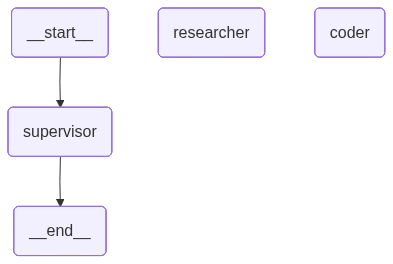

In [15]:
from IPython.display import Image, display

graph_png = supervisor.get_graph().draw_mermaid_png()
display(Image(graph_png))

Both subagents (researcher and coder) can see each other's work as all progress is recorded in the messages list. Each subagents could be more complex. For instance, a subagent could be its own graph that maintains internal state and only outputs a summary of work it did.

After execution of agent, we route back to the supervisor node which decides if there is more work to be done and which agent to delegate that to if needed. You could also have each subagent make a decision as to whether its output should be returned directly to the user. For this, you'd replace the hard edge between researcher and supervisor with a conditional edge which would read some state key updated by researcher.

# Best Practices

There is tradeoff between autonomy and reliability. More agency, lower reliability and higher costs. If you move towards chain, you decrease agency, increase reliability. Below are some of the objectives for LLM applications in general.
- Latency: Minimize time to get final answer
- Autonomy: Minimize interruptions for human input
- Variance: Minimize vaariations

These are either-or goals. If you increase reliability, you have to increase latency. Below are some of the techniques which can be used to achieve this.
- Streaming Output: You can accept some latency if there is some immediate output for user to see.
- Structured Output: Asking LLM for specific format makes it more likely that it will conform to expectations.
- Human in the loop: Human intervention can be useful to interrupt, approve, fork or undoing something agents suggested or did
- Double texting mode: The longer an LLM takes to answer, the more likely it is that the user might ask something else before previous request has finished.
## Structured Output

You may need output in certain format because downstream application requires data in specific schema or to reduce variance. There are few ways to achieve this.
1. Using prompting, you can ask LLM to return output in the desired format. However, this is more like a suggestion to LLM and not a guarantee that the output will be in this format.
2. Tool calling is another alternative to pick from a list of possible output schemas and to produce something that conforms to the chosen schema. This requires a name to identify, description to help LLM decide when to choose this tool and a schema for the desired output format.
3. JSON mode is available in latest LLMs that enforce the LLM to output a valid JSON document.

LangChain models implement a common interface, a method `with_structured_output` to return structured output. By invoking this method and passing in a JSON schema or Pydantic or Zod (in Javascript), the model will add necessary model parameters and output parsers are necessary to produce and return the structured output.

In [16]:
from pydantic import BaseModel, Field


class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

Here, you explicitly added description to each field. This along with the name of the field is the information LLM uses to decide what part of the output should go in each field. You could also define the schema in raw JSON like below.

```python
{'properties': {'setup': {'description': 'The setup of the joke',
    'title': 'Setup',
    'type': 'string'},
 'punchline': {'description': 'The punchline to the joke',
    'title': 'Punchline',
    'type': 'string'}},
 'required': ['setup', 'punchline'],
 'title': 'Joke',
 'type': 'object'}
```

Let's see example usage.

In [17]:
# from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_mistralai import ChatMistralAI

# model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# model = ChatOllama(model='gpt-oss:20b', temperature=0)
model = ChatMistralAI(model='mistral-medium-latest', temperature=0)
model = model.with_structured_output(Joke) # specify output format

model.invoke("Tell me a joke about cats")

/Users/piyushpatel/IdeaProjects/langchain-exploration/.venv/lib/python3.11/site-packages/pydantic/json_schema.py:335: ResourceWarning: unclosed <ssl.SSLSocket fd=113, family=2, type=1, proto=0, laddr=('192.168.2.22', 60751), raddr=('104.18.23.152', 443)>
  mapping[key] = getattr(self, method_name)


Joke(setup='Why was the cat sitting on the computer?', punchline='Because it wanted to keep an eye on the mouse!')

Low temperature is good for structured output as it reduces the chance the LLM will produce invalid output. You also attach the schema to the model which will produce output which matches the schema. When you pass Pydantic or Zod for schema, it will also perform validation. If LLM produces output that doesn't conform, a validation error will be returned instead of the failed output.

### Intermediate Output

The more complex LLM architecture, the more time it takes to execute. Most users expect application to produce some output within seconds. You could use streaming output. To generate immediate output with LangGraph, you have to invoke the graph with the `stream` method which will yield the output of each node as soon as each finishes.

In [18]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
# from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_mistralai import ChatMistralAI
from langchain_ollama import OllamaEmbeddings

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]

# embeddings = OpenAIEmbeddings()
# model = ChatOpenAI(temperature=0.1)
embeddings = OllamaEmbeddings(model='embeddinggemma')
model = ChatMistralAI(model='mistral-large-latest', temperature=0.1)

# Create embeddings for tools
tools_retriever = InMemoryVectorStore.from_documents(
    [
        Document(
            tool.description, 
            metadata={"name": tool.name}) for tool in tools
    ],
    embeddings,
).as_retriever()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state: State) -> State:
    selected_tools = [
        tool for tool in tools if tool.name in state["selected_tools"]
    ]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs = tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}


# Build Graph
builder = StateGraph(State)
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

/var/folders/gb/6k7kx0813nj31c19df8s6xs40000gp/T/ipykernel_41682/2893227323.py:28: ResourceWarning: unclosed <ssl.SSLSocket fd=112, family=2, type=1, proto=0, laddr=('192.168.2.22', 60793), raddr=('104.18.23.152', 443)>
  model = ChatMistralAI(model='mistral-large-latest', temperature=0.1)
/var/folders/gb/6k7kx0813nj31c19df8s6xs40000gp/T/ipykernel_41682/2893227323.py:31: ResourceWarning: unclosed <socket.socket fd=104, family=2, type=1, proto=6, laddr=('127.0.0.1', 60754), raddr=('127.0.0.1', 11434)>
  tools_retriever = InMemoryVectorStore.from_documents(


In [19]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

input = {
    "messages": [
        HumanMessage("""How old was the 30th president of the United States 
            when he died?""")
    ]
}
for c in graph.stream(input, stream_mode='updates'):
    print(c)

{'select_tools': {'selected_tools': ['duckduckgo_search', 'calculator']}}
{'model': {'messages': AIMessage(content="The 30th president of the United States was **Calvin Coolidge**. He was born on **July 4, 1872**, and died on **January 5, 1933**.\n\nLet's calculate his age at the time of his death.", additional_kwargs={'tool_calls': [{'id': 'JCOrxR8aC', 'function': {'name': 'calculator', 'arguments': '{"query": "(1933 - 1872) - ( (1 + 5) / 365 )"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 179, 'total_tokens': 272, 'completion_tokens': 93}, 'model_name': 'mistral-large-latest', 'model': 'mistral-large-latest', 'finish_reason': 'tool_calls'}, id='run--9d66d497-1c26-4042-aaaa-5f351fcaad4a-0', tool_calls=[{'name': 'calculator', 'args': {'query': '(1933 - 1872) - ( (1 + 5) / 365 )'}, 'id': 'JCOrxR8aC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 179, 'output_tokens': 93, 'total_tokens': 272})}}
{'tools': {'messages': [ToolMessage(content="Error: ValueE

Each output entry is a dictionary with the name of the node that emitted as the key and the output of that node as the value. This gives below information.
- Where the application currently is
- Each update to the shared state of the application which together build up to the final output of the graph.

LangGraph also supports additional stream modes.
- `updates`: This is the default mode as mentioned above.
- `values`: This mode yields the current state of the graph every time it changes (i.e. after each set of nodes finish executing). This can be useful when the output you display to your users closely tracks the shape of the graph state.
- `debug`: This mode yields detailed events every time something happens in the graph. These events include *checkpoint* event (whenever a new checkpoint of the current state is saved to the database), *task* events emitted whenever a node is about to start running, *task_result* events emitted whenever a node finishes running.

You can also combine these modes, requesting both `updates` and `values` by passing a list to the `stream()` method with `stream_mode` argument.

### Streaming output Token-by-token

When you need to get streaming output from each LLM call inside larger LLM application, you can use below technique. This can be useful for interactive chatbot where you want each word to be displayed as soon as it is produced by LLM.

```python
input = {
    "messages": [
        HumanMessage("""How old was the 30th president of the United States 
            when he died?""")
    ]
}
output = app.astream_events(input, version="v2")

async for event in output:
    if event["event"] == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            print(content)
```

### Human in the loop

The shared state pattern in LlangGraph makes it easier to observe, interrupt and modify the application. This makes it possible to use human-in-the-loop modes. For human in the loop modes, you first need to attach a checkpointers to the graph.

In [20]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer=MemorySaver())

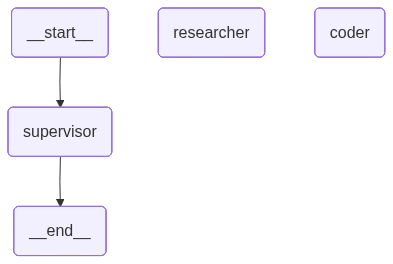

In [21]:
from IPython.display import Image, display

graph_png = supervisor.get_graph().draw_mermaid_png()
display(Image(graph_png))

With this, it returns an instance of the graph that stores the state at the end of each step, so every invocation after the first doesn't start from a blank slate. Any time the grpah is called, it starts by using the checkpointer to fetch the most recent saved state and combines the new input with the previous state. Then only it executes the first nodes. This is key to enabling human-in-the-loop modalities which all rely on the graph rememberng the previous state.

The first mode **interrupt** is simplest form of control - the user is looking at the streaming output of the application as it is produced and manually interrupts it when he sees fit. The state is saved as of the last complete step prior to the user hitting the interrupt button. At this point, user can choose to
- resume from that point onward
- send new input into the application which will cancel any future steps that were pending and start dealing with the new input.
- do nothing and nothing else will run.

```python
import asyncio
from contextlib import aclosing

from langchain.schema import HumanMessage
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]
    
# Create a simple graph
builder = StateGraph(State)
# Add nodes and edges as needed
graph = builder.compile(checkpointer=MemorySaver())

event = asyncio.Event()

input = {
    "messages": [
        HumanMessage(
            "How old was the 30th president of the United States when he died?"
        )
    ]
}

config = {"configurable": {"thread_id": "1"}}

async with aclosing(graph.astream(input, config)) as stream:
    async for chunk in stream:
        if event.is_set():
            break
        else:
            print(chunk)  # do something with the output

# Simulate interruption after 2 seconds
# somewhere else in your application
await asyncio.sleep(2)
event.set()
```

I uses event or signal so that you can control interruption from outside of the running application. In Python using `aclosing` ensures the stream is properly closed when interrupted. The usage of checkpointer requires passing in an identifier for this thread to distinguish this interaction with the graph from all others.

A second control mode is **authorize** where the user defines upfront that they want the application to hand off control to them every time a particular node is about to be called. This is implemented for tool confirmation (i.e. before any tool is called, the application will pause and ask for confirmation) at which point the user can:
- resume computation after accepting the tool call
- send a new message to guide the bot in a different direction in which case the tool will not be called.
- do nothing

```python
input = {
    "messages": [
        HumanMessage("""How old was the 30th president of the United States 
            when he died?""")
    ]
}

config = {"configurable": {"thread_id": "1"}}

output = graph.astream(input, config, interrupt_before=['tools'])

async for c in output:
    ... # do something with the output
```

This will run the graph until it is about to enter the node called `tools`. Thus giving you the chance to inspect the current state and decide whether to proceed or not. The `interrupt_before` is a list where order is not important. If you pass multiple node names, it will interrupt before entering each of them.

**Resume:** To proceed from an interrupted graph, you need to re-invoke the graph with null input (`None` in Python). This is taken as a signal to continue processing the previous non-null input.

```python
config = {"configurable": {"thread_id": "1"}}

output = graph.astream(None, config, interrupt_before=['tools'])

async for c in output:
    ... # do something with the output
```

**Restart:** If you want an interrupted graph to start over from the first node with additional new input, you need to invoke it with new input.

```python
input = {
    "messages": [
        HumanMessage("""How old was the 30th president of the United States 
            when he died?""")
    ]
}

config = {"configurable": {"thread_id": "1"}}

output = graph.astream(input, config)

async for c in output:
    ... # do something with the output
```

This keeps the current state of the graph, merge it with the new input and start again from the first node. If you wnt to lose the current state, just change the `thread_id` which will start a new interaction from a blank state. 

**Edit State:**  If you want to update the state of the graph before resuming, you can use `update_state` method.

```python
config = {"configurable": {"thread_id": "1"}}

state = graph.get_state(config)

# something you want to add or replace
update = { }

graph.update_state(config, update)
```

This will create a new checkpoint containing your update.

**Fork:** You can also browse the history of all past statess the graph has passed through and any of those can be visited again to get an alternative answer. This can be useful for creative applications where each run through the graph is expected to produce different output.

```python
config = {"configurable": {"thread_id": "1"}}

history = [
    state for state in
    graph.get_state_history(config)
]

# replay a past state
graph.invoke(None, history[2].config)
```

The states returned from the history method are sorted wit hthe most recent first and the oldest last. 

## Multi-tasking LLMs

Dealing with concurrent inputs will remain a challenge even after LLMs become fast as latency improvements will unlock door for more complex use cases. 

Any input received while processing a previous one is **rejected**. This is the simplest strategy but unlikely to cover all needs.

Another option is to treat any new input as an **independent invocation** to create a new thread and producing output in that context. 

Alternatively, any input received while processing a previous one is **queued up** and handled when the current one finished. This supports receiving an aribtrary number of concurrent requests. As you wait for current input to finish processing, it doesn't matter if the new input arrives almost immediately after we start handling the current input or immediately before we finish. The strategy also has few drawbacks. It may take a while to process all queued inputs. The queu may grow unbounded if inputs are produced at a rate faster than processed. The inputs may be stale by the time they get processed, given that they are queued before seeing the response to the previous one and not altered afterwards.

Another option is to **interrupt** when a new input is received while another is being processed. This strategy can vary by what is kept of the interrupted run. There are several options
- Keep nothing. The previous input is completely forgotten as if it had never been sent.
- Keep the last completed step. In checkpointing app, keep the state procued by the last completed step, discard any pending state updates from the currently executing step and start handling the new input in that context.
- Keep the last completed step as well as the current in-progress step. Attempt to interrupt the current step while taking care to save any incomplete updates to state that were being produced at that time.
- Wait for the current node to finish then save and interrupt.

This has advantage compared to queuing that new input is handled as soon as possible, reducing latency. The drawback is that this strategy is limited to processing one input at a time and old input is abandoned when new input is received. The final output procued are very sensitive to when the new input is received. The new input will be handled in the context of the incomplete progress for handling the previous input. This can result in unpredictable outcomes if designed inappropriately.

Another option is to handle new input in parallel, **forking** the state of the thread as it is when the new input is received and merging the final states as inputs finish being handled. You need to design state to either be mergeable without conflicts or having the user manually resolve conflicts before you're able to make sense of the output or send new input in this thread.